In [56]:
import pandas as pd
import seaborn as sns
import numpy as np
import pygeohash as pgh
import ast
from collections import Counter
from geopy.distance import geodesic
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Summary

### The code below is for the paper: Predicting AirBnb Prices and AirBnb Listing Availability

#### It is seperated into:
* Data processing (cleaning, feature engineering, and formatting)
* Modeling for Predicting AirBnb Prices
* Modeling for AirBnb Listing Availability

# Data Processing

In [2]:
df = pd.read_csv("listings.csv")

In [3]:
filt_df = df[["name", "host_is_superhost", "host_neighbourhood", "latitude", "longitude",
   "property_type", "room_type", "amenities", "price", "bedrooms",
   "beds", "review_scores_rating", 'availability_90']]

In [4]:
downtown_austin = (30.266666, -97.733330)

In [5]:
filt_df["dist_to_dt"] = filt_df.apply(lambda x: geodesic(downtown_austin, (x["latitude"], x["longitude"])).miles, axis=1)

<ipython-input-5-de5938311470>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_df["dist_to_dt"] = filt_df.apply(lambda x: geodesic(downtown_austin, (x["latitude"], x["longitude"])).miles, axis=1)


<AxesSubplot:xlabel='dist_to_dt', ylabel='Count'>

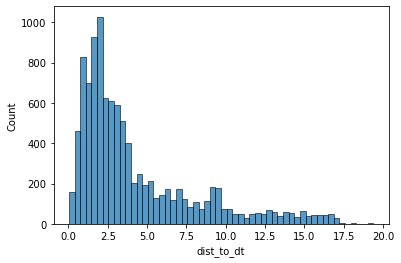

In [7]:
sns.histplot(filt_df["dist_to_dt"])

In [8]:
filt_df = filt_df[filt_df.dist_to_dt <= 5]

In [9]:
filt_df.price = filt_df.price.str.replace("$", "")
filt_df.price = filt_df.price.str.replace(",", "").astype(float)

<ipython-input-9-d46267ce030b>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  filt_df.price = filt_df.price.str.replace("$", "")


In [10]:
filt_df.host_is_superhost = np.where(filt_df.host_is_superhost == "f", 0, 1)

In [13]:
filt_df.amenities = [ast.literal_eval(x) for x in filt_df.amenities]

In [14]:
all_amenities = []
for x in filt_df.amenities:
    all_amenities += x

In [16]:
amenities_dict = dict(Counter(all_amenities))

In [18]:
filt_df = filt_df[filt_df.price>=15]

In [19]:
filt_df.reset_index(inplace=True, drop=True)

In [20]:
amenities_prices = {}
for a in amenities_dict.keys():
    amenities_price = []
    i = 0
    for listing in filt_df.amenities:
        if a in listing:
            price = filt_df.loc[i, "price"]
        amenities_price.append(price)
        i+=1
    amenities_prices[a] = np.mean(amenities_price)

In [22]:
amenities_prices = dict(sorted(amenities_prices.items(), key=lambda item: item[1]))

In [23]:
filt_amenities = ["pool", "baby", "barbeque", "hot tub", "pets", "fire"]

In [24]:
lower_amenities = []
for amenities in filt_df.amenities:
    amen = [x.lower() for x in amenities]
    lower_amenities.append(amen)

In [25]:
filt_df.amenities = lower_amenities

In [26]:
all_amenities = []
for al in filt_df.amenities:
    listing_amen = []
    for a in al:
        for fa in filt_amenities:
            if fa in a:
                listing_amen.append(fa)
    all_amenities.append(listing_amen)

In [28]:
filt_df['filt_amenitites'] = all_amenities

In [29]:
amen_dummies = filt_df['filt_amenitites'].str.join('|').str.get_dummies().add_prefix('amenitites_')

In [30]:
filt_df=pd.concat([filt_df, amen_dummies], axis=1)

In [31]:
filt_df["num_amenities"] = [len(x) for x in filt_df.amenities]

In [32]:
filt_df.drop_duplicates(subset="name", inplace=True)

In [33]:
filt_df = filt_df[~(filt_df.host_neighbourhood.isna())]

In [34]:
filt_df = filt_df[~(filt_df.review_scores_rating.isna())]

In [35]:
filt_df["geohash"] = filt_df.apply(lambda x: pgh.encode(x["latitude"], x["longitude"], precision=5), axis=1)

In [36]:
geos = filt_df.groupby("geohash")["price"].count() > 30

In [37]:
filt_df = filt_df[filt_df.geohash.isin(geos[geos.values].index)]

In [38]:
prop_type = filt_df.groupby("property_type")["name"].count().sort_values()

In [39]:
allowed_prop_type = prop_type[prop_type > 100].index

In [40]:
filt_df = filt_df[filt_df.property_type.isin(allowed_prop_type)]

In [41]:
filt_df.bedrooms.fillna(0, inplace=True)

In [42]:
filt_df = filt_df[filt_df.price <9999]

In [43]:
filt_df["bedroom_cat"] = np.where(filt_df.bedrooms == 1, "one",
        np.where(filt_df.bedrooms == 2, "two",
                np.where(filt_df.bedrooms == 3, "three",
                        np.where(filt_df.bedrooms > 3, "greater_than_3", "zero"))))

In [48]:
filt_df["log_price"] = np.log(filt_df.price)

<AxesSubplot:xlabel='property_type'>

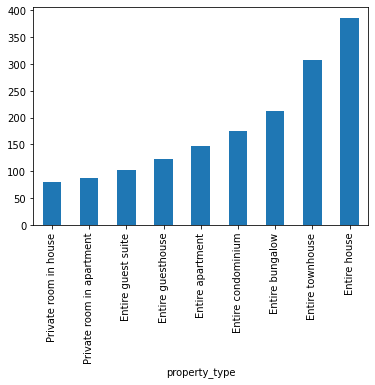

In [44]:
filt_df.groupby("property_type")["price"].mean().sort_values().plot(kind="bar")

<AxesSubplot:xlabel='geohash'>

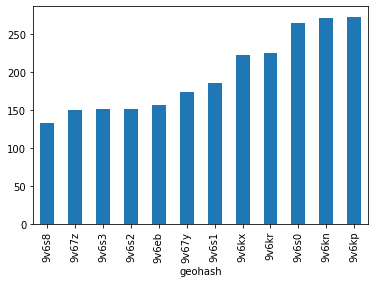

In [45]:
filt_df.groupby("geohash")["price"].mean().sort_values().plot(kind="bar")

<AxesSubplot:xlabel='bedroom_cat'>

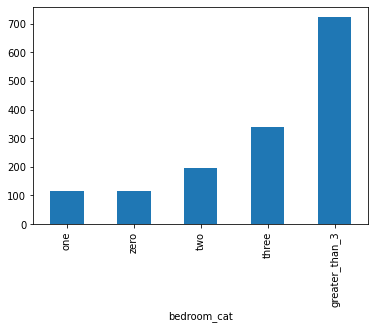

In [46]:
filt_df.groupby("bedroom_cat")["price"].mean().sort_values().plot(kind="bar")

Text(0.5, 0.98, 'Categorical Features')

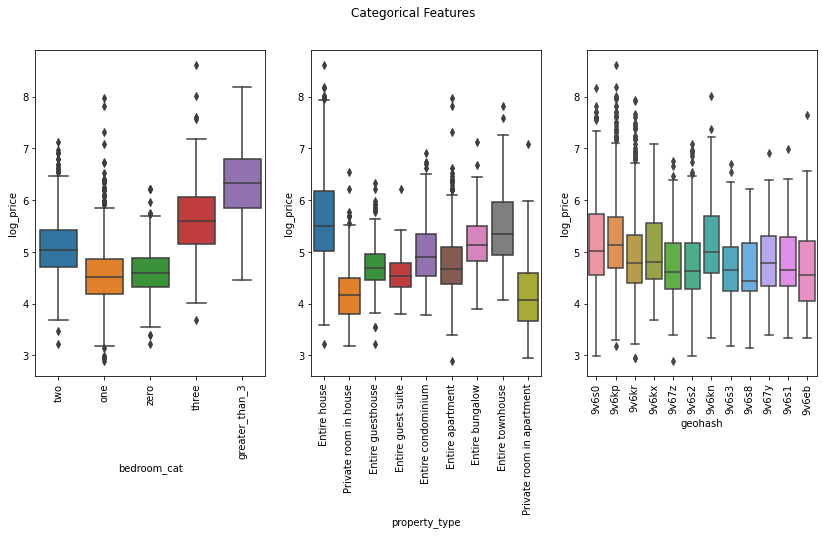

In [49]:
fig, axes = plt.subplots(figsize=(14, 6),ncols=3)
sns.boxplot(x="bedroom_cat", y="log_price", data=filt_df, ax=axes[0])
sns.boxplot(x="property_type", y="log_price", data=filt_df, ax=axes[1])
sns.boxplot(x="geohash", y="log_price", data=filt_df, ax=axes[2])
for ax in axes:
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
fig.suptitle("Categorical Features")

<AxesSubplot:xlabel='geohash', ylabel='log_price'>

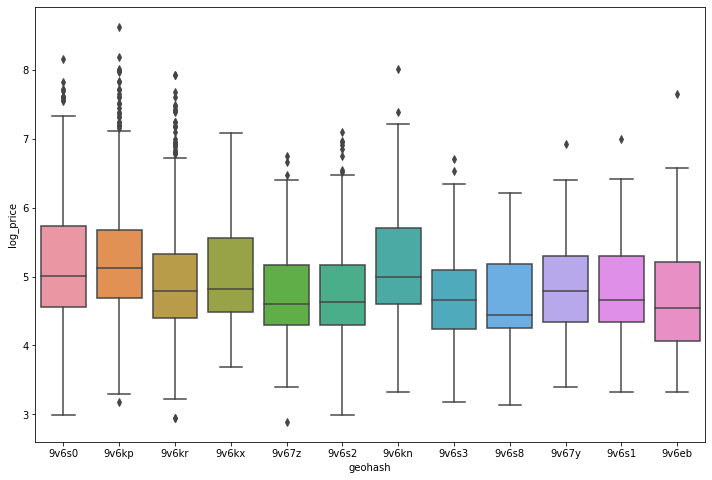

In [50]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(x="geohash", y="log_price", data=filt_df)

In [51]:
prop_type_df = pd.get_dummies(filt_df.property_type, prefix="prop_")
geohash_df = pd.get_dummies(filt_df.geohash, prefix="geohash_")
bedroom_df = pd.get_dummies(filt_df.bedroom_cat, prefix="bedroom_")

Text(0.5, 0.98, 'Numerical Features')

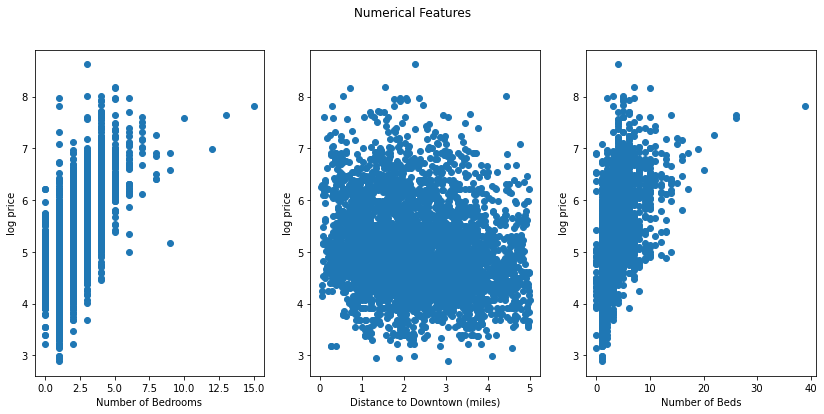

In [52]:
fig, axes = plt.subplots(figsize=(14, 6), ncols=3)
axes[0].scatter(filt_df.bedrooms, filt_df.log_price)
axes[1].scatter(filt_df.dist_to_dt, filt_df.log_price)
axes[2].scatter(filt_df.beds, filt_df.log_price)
axes[0].set_xlabel("Number of Bedrooms")
axes[1].set_xlabel("Distance to Downtown (miles)")
axes[2].set_xlabel("Number of Beds")
axes[0].set_ylabel("log price")
axes[1].set_ylabel("log price")
axes[2].set_ylabel("log price")
fig.suptitle("Numerical Features")

In [81]:
final_df = filt_df[["name", 'host_is_superhost', 'price',
       'bedrooms', 'beds', 'review_scores_rating', 'availability_90',
       'dist_to_dt', 'amenitites_baby',
       'amenitites_barbeque', 'amenitites_fire', 'amenitites_hot tub',
       'amenitites_pets', 'amenitites_pool', 'log_price']]

In [82]:
final_df = pd.concat([final_df, prop_type_df, geohash_df, bedroom_df],axis=1)

In [83]:
final_df = final_df[final_df.price < 9999]

In [84]:
scaler = StandardScaler()

In [87]:
import plotly.express as px
px.set_mapbox_access_token("pk.eyJ1IjoiY29keWdyZWNvIiwiYSI6ImNrbDVsancxdDI0enEycHBsMXl3eG9lNGYifQ._GaFrtS_NTrW7xcNs5w8Aw")
fig = px.scatter_mapbox(filt_df, lat="latitude", lon="longitude", color="log_price",
                  color_continuous_scale=px.colors.diverging.RdYlGn, size_max=15, zoom=10)
fig.show()

In [88]:
final_df.fillna(0, inplace=True)
X = final_df[final_df.columns[1:]]
X = X.drop(["price", "log_price"], axis=1)
X = scaler.fit_transform(X)
y = final_df.log_price

# Modeling for Predicting AirBnb Prices

In [66]:
def generate_train_test_acc(algo, num_size=20):
    testing_errors = []
    training_errors = []
    index = np.linspace(.1, .9, num=num_size)
    for size in index:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=SEED)
        model = algo.fit(X_train, y_train)
        testing_pred = model.predict(X_test)
        training_pred = model.predict(X_train)
        testing_rmse = np.sqrt(mean_squared_error(y_test, testing_pred))
        training_rmse = np.sqrt(mean_squared_error(y_train, training_pred))
        testing_errors.append(testing_rmse)
        training_errors.append(training_rmse)
    return testing_errors, training_errors, index

In [67]:
def plot_errors(testing, training, idx, title):
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.plot(idx, testing, label="testing rmse", marker='o')
    ax.plot(idx, training, label="training rmse", marker='o')
    ax.set_xlabel("Percentage of Dataset as Testing")
    ax.set_ylabel("Root Mean Squared Error")
    ax.set_title(title)
    ax.legend()
    return fig, ax

In [89]:
SEED = 12893123

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=SEED)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.24913708398574091


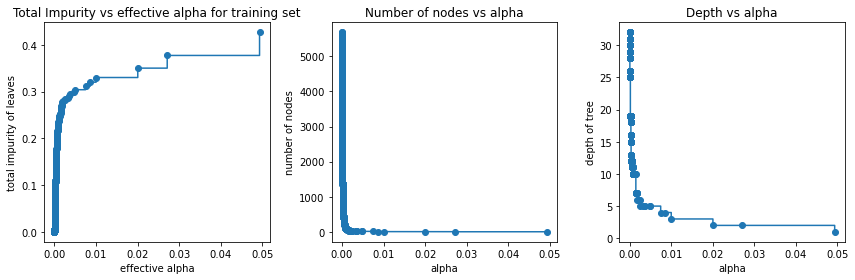

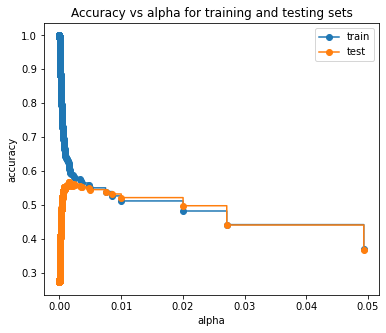

In [91]:
"""
Code used in this cell is similar to:
https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py
"""
clf = DecisionTreeRegressor(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
fig, axes = plt.subplots(figsize=(12, 4), ncols=3)
axes[0].plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
axes[0].set_xlabel("effective alpha")
axes[0].set_ylabel("total impurity of leaves")
axes[0].set_title("Total Impurity vs effective alpha for training set")
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
axes[1].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
axes[1].set_xlabel("alpha")
axes[1].set_ylabel("number of nodes")
axes[1].set_title("Number of nodes vs alpha")
axes[2].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
axes[2].set_xlabel("alpha")
axes[2].set_ylabel("depth of tree")
axes[2].set_title("Depth vs alpha")
fig.tight_layout()
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots(figsize=(6,5))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

CPU times: user 734 ms, sys: 0 ns, total: 734 ms
Wall time: 733 ms


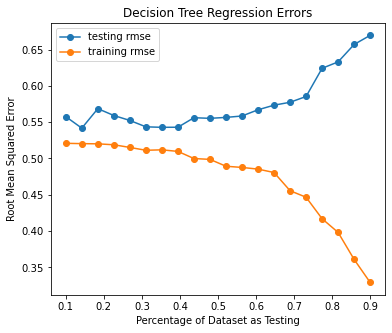

In [94]:
%%time
dt = DecisionTreeRegressor(ccp_alpha=ccp_alphas[np.argmax(test_scores)])
testing_errors, training_errors, idx = generate_train_test_acc(dt)
dt_fig, dt_ax = plot_errors(testing_errors, training_errors, idx, "Decision Tree Regression Errors")

In [95]:
loss_curves = []
alphas = [.1, .01, .001, .0001]
for alpha in alphas:
    mlp = MLPRegressor(max_iter=1000, learning_rate_init=alpha)
    mlp.fit(X_train, y_train)
    loss_curves.append(mlp.loss_curve_ )

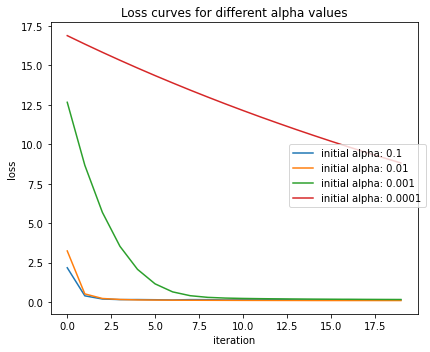

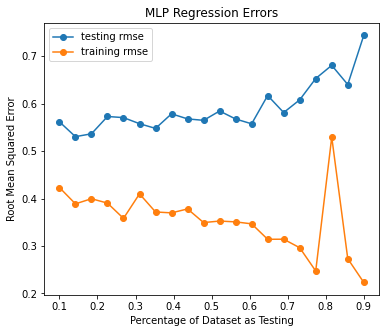

In [96]:
fig, ax = plt.subplots(figsize=(6, 5))
for i in range(len(loss_curves)):
    plt.plot(loss_curves[i][:20], label="initial alpha: {0}".format(alphas[i]))
fig.legend(loc=5)
ax.set_title("Loss curves for different alpha values")
ax.set_xlabel("iteration")
ax.set_ylabel("loss")
fig.tight_layout()
mlp = MLPRegressor(max_iter=1000, learning_rate_init=0.01)
testing_errors, training_errors, idx = generate_train_test_acc(mlp)
dt_fig, dt_ax = plot_errors(testing_errors, training_errors, idx, "MLP Regression Errors")

In [97]:
#MAX ITERS SET HIGHER FOR CONVERGENCE

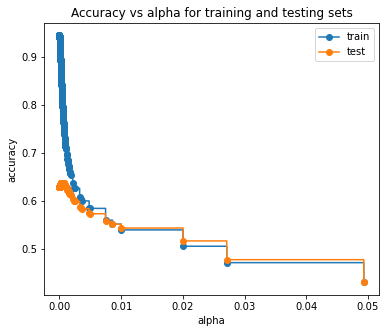

In [98]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = RandomForestRegressor(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)


train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots(figsize=(6,5))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

(<Figure size 432x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Random Forest Regression Errors'}, xlabel='Percentage of Dataset as Testing', ylabel='Root Mean Squared Error'>)

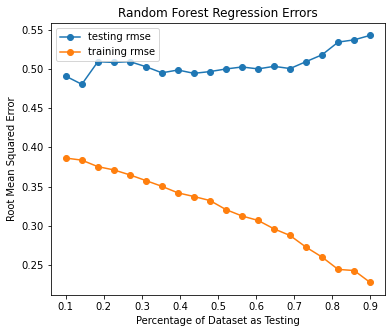

In [99]:
rf = RandomForestRegressor(ccp_alpha=ccp_alphas[np.argmax(test_scores)])
testing_errors, training_errors, idx = generate_train_test_acc(rf)
plot_errors(testing_errors, training_errors, idx, "Random Forest Regression Errors")

for rbf kernel: best training 0.4009169054969272
 best testing: 0.500806673132675
for poly kernel: best training 0.39041251209018163
 best testing: 0.5275698313923621


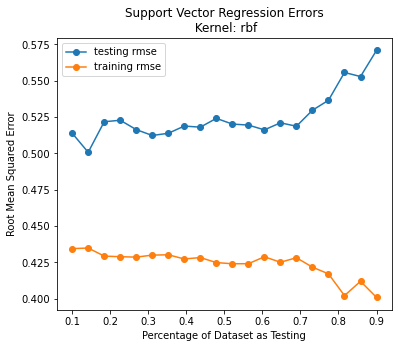

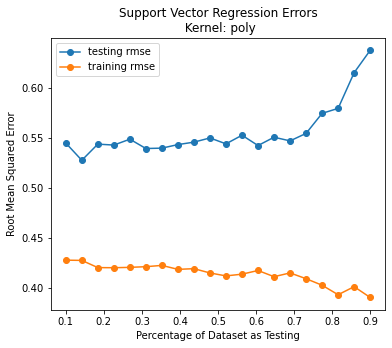

In [100]:
kernels = ["rbf", "poly"]
for k in kernels:
    svr = SVR(kernel=k)
    testing_errors, training_errors, idx = generate_train_test_acc(svr)
    print("for {0} kernel: best training {1}\n best testing: {2}".format(k, min(training_errors), min(testing_errors)))
    plot_errors(testing_errors, training_errors, idx, "Support Vector Regression Errors\n Kernel: {0}".format(k))

for k=2: best training 0.32961328013776053
 best testing: 0.5836114050739057
for k=4: best training 0.4184797417298758
 best testing: 0.5347246269630656
for k=6: best training 0.45262091536279303
 best testing: 0.5320572399148447
for k=8: best training 0.4705670160242822
 best testing: 0.5255575038369988


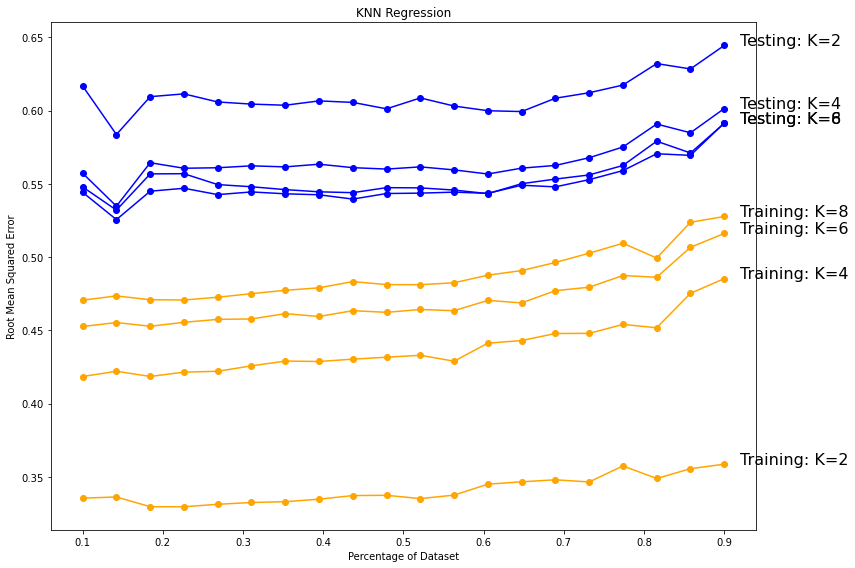

In [101]:
ks = [2, 4, 6, 8]
fig, ax = plt.subplots(figsize=(12, 8))
for k in ks:
    knn = KNeighborsRegressor(n_neighbors=k)
    testing, training, idx = generate_train_test_acc(knn)
    print("for k={0}: best training {1}\n best testing: {2}".format(k, min(training), min(testing)))
    ax.plot(idx, testing, label="testing rmse", marker='o', color="blue")
    ax.plot(idx, training, label="training rmse", marker='o', color="orange")
    ax.set_xlabel("Percentage of Dataset")
    ax.set_ylabel("Root Mean Squared Error")
    ax.text(x=.92, y=training[-1], s="Training: K={0}".format(k), size=16)
    ax.text(x=.92, y=testing[-1], s="Testing: K={0}".format(k), size=16)
ax.set_title("KNN Regression")
fig.tight_layout()

In [102]:
knn = KNeighborsRegressor(n_neighbors=8)
svr = SVR(kernel="rbf")
rf = RandomForestRegressor(ccp_alpha=.0004)
mlp = MLPRegressor(max_iter=1000, learning_rate_init=0.01)
dt = DecisionTreeRegressor(ccp_alpha=.001)

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.35, random_state=SEED)

In [104]:
def accuracy_plot(model, algo_name):
    testing, training, idx = generate_train_test_acc(model)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    line = np.arange(0, max(np.exp(preds)))
    plt.scatter(np.exp(preds), np.exp(y_test), alpha=.5)
    plt.plot(line , line, color="black", ls="--")
    plt.xlabel("predictions")
    plt.ylabel("actuals")
    plt.title("Actuals vs Predictions {0}".format(algo_name))

CPU times: user 7.05 s, sys: 15.6 ms, total: 7.06 s
Wall time: 7.07 s


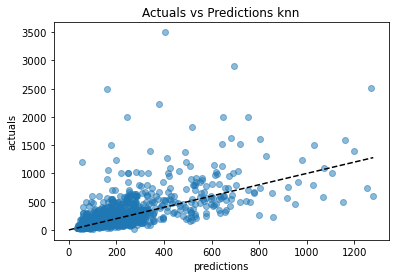

In [105]:
%%time
accuracy_plot(knn, "knn")

CPU times: user 11 s, sys: 31.2 ms, total: 11 s
Wall time: 11 s


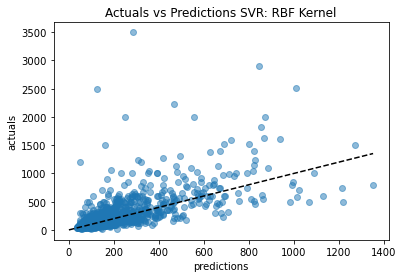

In [106]:
%%time
accuracy_plot(svr, "SVR: RBF Kernel")

CPU times: user 33.2 s, sys: 141 ms, total: 33.3 s
Wall time: 33.7 s


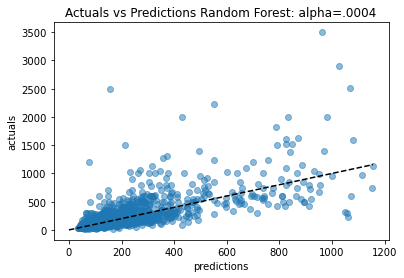

In [107]:
%%time
accuracy_plot(rf, "Random Forest: alpha=.0004")

CPU times: user 45.1 s, sys: 28.8 s, total: 1min 13s
Wall time: 16.7 s


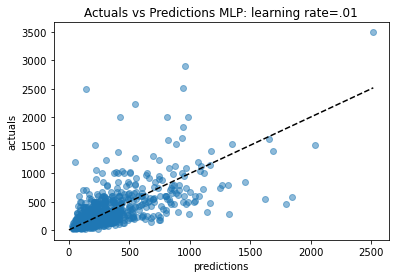

In [108]:
%%time
accuracy_plot(mlp, "MLP: learning rate=.01")

CPU times: user 734 ms, sys: 15.6 ms, total: 750 ms
Wall time: 746 ms


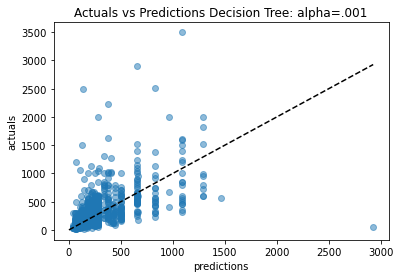

In [109]:
%%time
accuracy_plot(dt, "Decision Tree: alpha=.001")

In [110]:
problem_two_df = final_df.copy()

In [111]:
problem_two_df["booked_90"] = np.where(problem_two_df.availability_90 >0, 1, 0)

In [112]:
problem_two_df = problem_two_df.drop(["availability_90", "name"], axis=1)

In [113]:
problem_two_df.fillna(0, inplace=True)

In [114]:
y = problem_two_df.booked_90

In [115]:
X = problem_two_df.drop("booked_90", axis=1)

In [116]:
X = scaler.fit_transform(X)

In [117]:
filt_df["booked_90"] = np.where(filt_df.availability_90 > 0, 1, 0)

In [118]:
import plotly.express as px
px.set_mapbox_access_token("pk.eyJ1IjoiY29keWdyZWNvIiwiYSI6ImNrbDVsancxdDI0enEycHBsMXl3eG9lNGYifQ._GaFrtS_NTrW7xcNs5w8Aw")
fig = px.scatter_mapbox(filt_df, lat="latitude", lon="longitude", color="booked_90",
                  color_continuous_scale=px.colors.diverging.RdYlGn, size_max=15, zoom=10)
fig.show()

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=SEED)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.02498797124608848


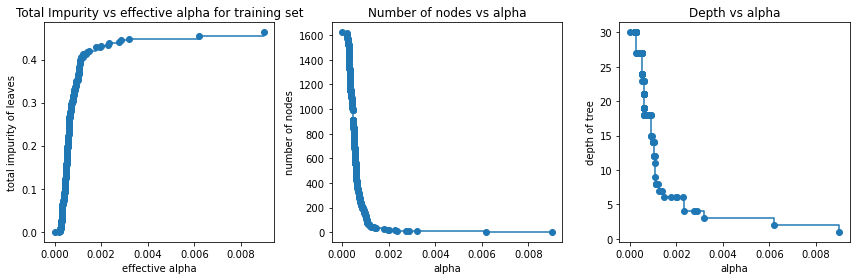

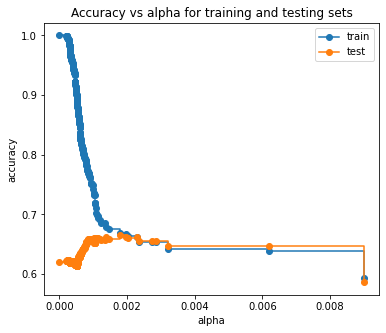

In [120]:
clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
fig, axes = plt.subplots(figsize=(12, 4), ncols=3)
axes[0].plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
axes[0].set_xlabel("effective alpha")
axes[0].set_ylabel("total impurity of leaves")
axes[0].set_title("Total Impurity vs effective alpha for training set")
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
axes[1].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
axes[1].set_xlabel("alpha")
axes[1].set_ylabel("number of nodes")
axes[1].set_title("Number of nodes vs alpha")
axes[2].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
axes[2].set_xlabel("alpha")
axes[2].set_ylabel("depth of tree")
axes[2].set_title("Depth vs alpha")
fig.tight_layout()
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots(figsize=(6,5))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [121]:
def generate_train_test_acc(algo, num_size=20):
    testing_errors = []
    training_errors = []
    index = np.linspace(.1, .9, num=num_size)
    for size in index:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=SEED)
        model = algo.fit(X_train, y_train)
        testing_pred = model.predict(X_test)
        training_pred = model.predict(X_train)
        testing_score = model.score(X_test, y_test)
        training_score = model.score(X_train, y_train)
        testing_errors.append(testing_score)
        training_errors.append(training_score)
    return testing_errors, training_errors, index

In [122]:
def plot_errors(testing, training, idx, title):
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.plot(idx, testing, label="testing score", marker='o')
    ax.plot(idx, training, label="training score", marker='o')
    ax.set_xlabel("Percentage of Dataset as Testing")
    ax.set_ylabel("Mean Accuracy Score")
    ax.set_title(title)
    ax.legend()
    return fig, ax

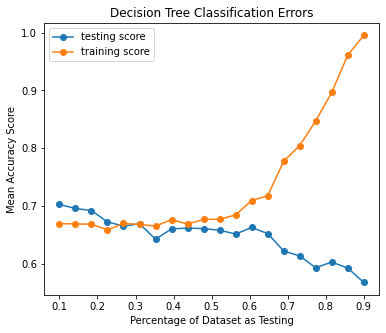

In [123]:
dt = DecisionTreeClassifier(ccp_alpha=ccp_alphas[np.argmax(test_scores)])
testing_errors, training_errors, idx = generate_train_test_acc(dt)
dt_fig, dt_ax = plot_errors(testing_errors, training_errors, idx, "Decision Tree Classification Errors")

/home/cody/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.



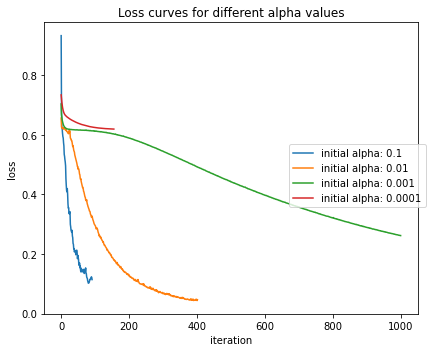

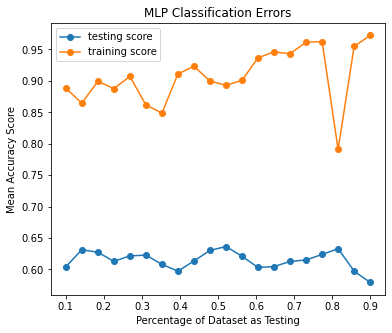

In [125]:
loss_curves = []
alphas = [.1, .01, .001, .0001]
for alpha in alphas:
    mlp = MLPClassifier(max_iter=1000, learning_rate_init=alpha, activation="logistic")
    mlp.fit(X_train, y_train)
    loss_curves.append(mlp.loss_curve_ )
fig, ax = plt.subplots(figsize=(6, 5))
for i in range(len(loss_curves)):
    plt.plot(loss_curves[i][:1000], label="initial alpha: {0}".format(alphas[i]))
fig.legend(loc=5)
ax.set_title("Loss curves for different alpha values")
ax.set_xlabel("iteration")
ax.set_ylabel("loss")
fig.tight_layout()
mlp = MLPClassifier(max_iter=1000, learning_rate_init=0.01)
testing_errors, training_errors, idx = generate_train_test_acc(mlp)
dt_fig, dt_ax = plot_errors(testing_errors, training_errors, idx, "MLP Classification Errors")

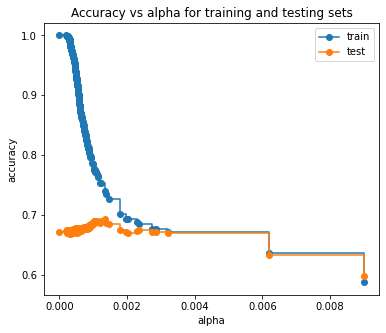

In [126]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = RandomForestClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)


train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots(figsize=(6,5))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

(<Figure size 432x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Random Forest Classification Errors'}, xlabel='Percentage of Dataset as Testing', ylabel='Mean Accuracy Score'>)

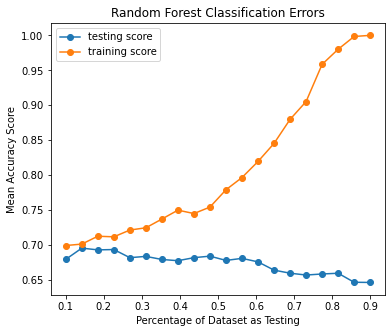

In [127]:
rf = RandomForestClassifier(ccp_alpha=ccp_alphas[np.argmax(test_scores)])
testing_errors, training_errors, idx = generate_train_test_acc(rf)
plot_errors(testing_errors, training_errors, idx, "Random Forest Classification Errors")

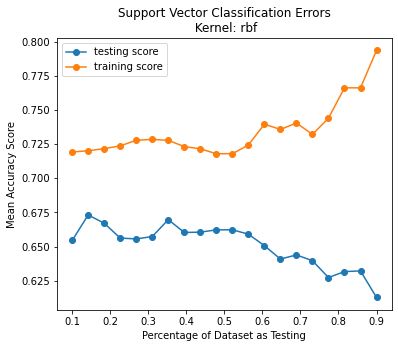

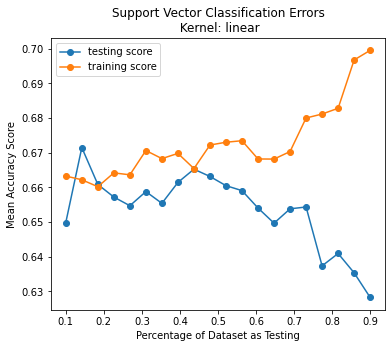

In [128]:
kernels = ["rbf", "linear"]
for k in kernels:
    svr = SVC(kernel=k)
    testing_errors, training_errors, idx = generate_train_test_acc(svr)
    plot_errors(testing_errors, training_errors, idx, "Support Vector Classification Errors\n Kernel: {0}".format(k))

for k=2: best training 0.7810945273631841
 best testing: 0.5181795067378592
for k=4: best training 0.7357142857142858
 best testing: 0.5390770872232595
for k=6: best training 0.7117750439367311
 best testing: 0.5473459589223792
for k=8: best training 0.6857798165137615
 best testing: 0.5517416730231376


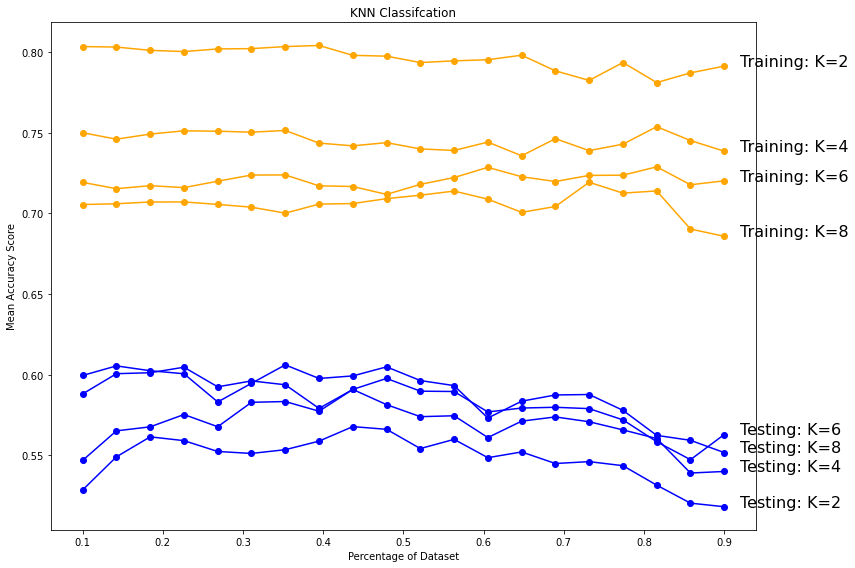

In [129]:
ks = [2, 4, 6, 8]
fig, ax = plt.subplots(figsize=(12, 8))
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    testing, training, idx = generate_train_test_acc(knn)
    print("for k={0}: best training {1}\n best testing: {2}".format(k, min(training), min(testing)))
    ax.plot(idx, testing, label="testing rmse", marker='o', color="blue")
    ax.plot(idx, training, label="training rmse", marker='o', color="orange")
    ax.set_xlabel("Percentage of Dataset")
    ax.set_ylabel("Mean Accuracy Score")
    ax.text(x=.92, y=training[-1], s="Training: K={0}".format(k), size=16)
    ax.text(x=.92, y=testing[-1], s="Testing: K={0}".format(k), size=16)
ax.set_title("KNN Classifcation")
fig.tight_layout()

In [130]:
knn = KNeighborsClassifier(n_neighbors=8)
svc = SVC(kernel="rbf", probability=True)
rf = RandomForestClassifier(ccp_alpha=0.0009)
mlp = MLPClassifier(max_iter=1000, learning_rate_init=0.01)
dt = DecisionTreeClassifier(ccp_alpha=.001)

In [131]:
def plot_roc(model, model_name):
    ns_probs = [0 for _ in range(len(y_test))]
    # fit a model
    model.fit(X_train, y_train)
    testing_score = model.score(X_test, y_test)
    training_score = model.score(X_train, y_train)
    print("testing score: {0}".format(testing_score))
    print("training score: {0}".format(training_score))
    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('{0}: ROC AUC={1}'.format(model_name, round(lr_auc, 3)))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='{0}'.format(model_name))
    # axis labels
    plt.title("{0} ROC Curve".format(model_name))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

testing score: 0.5998613037447988
training score: 0.7061838059446532
No Skill: ROC AUC=0.500
knn: ROC AUC=0.626


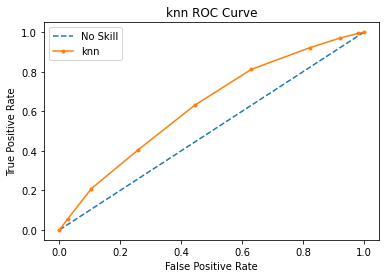

CPU times: user 859 ms, sys: 46.9 ms, total: 906 ms
Wall time: 902 ms


In [133]:
%%time
plot_roc(knn, "knn")

testing score: 0.6109570041608876
training score: 0.9142466689443116
No Skill: ROC AUC=0.500
mlp: ROC AUC=0.624


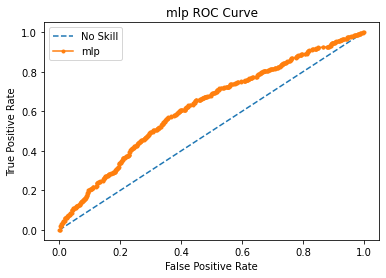

CPU times: user 5.89 s, sys: 3.72 s, total: 9.61 s
Wall time: 2.33 s


In [134]:
%%time

plot_roc(mlp, "mlp")

testing score: 0.6768377253814147
training score: 0.7967201913221729
No Skill: ROC AUC=0.500
random forest: ROC AUC=0.717


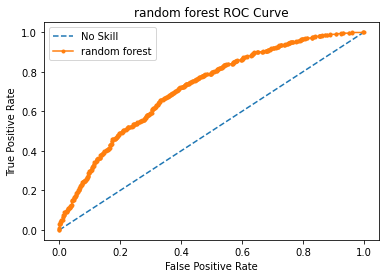

CPU times: user 672 ms, sys: 46.9 ms, total: 719 ms
Wall time: 741 ms


In [135]:
%%time

plot_roc(rf, "random forest")

testing score: 0.6622746185852982
training score: 0.7290741373419883
No Skill: ROC AUC=0.500
support vector machine: ROC AUC=0.681


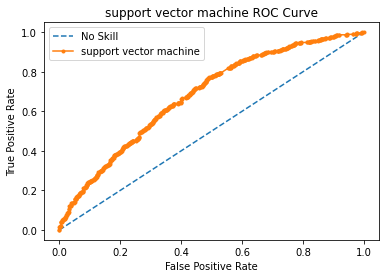

CPU times: user 2.48 s, sys: 93.8 ms, total: 2.58 s
Wall time: 2.71 s


In [136]:
%%time

plot_roc(svc, "support vector machine")

testing score: 0.6539528432732317
training score: 0.7430816535702084
No Skill: ROC AUC=0.500
decision tree: ROC AUC=0.678


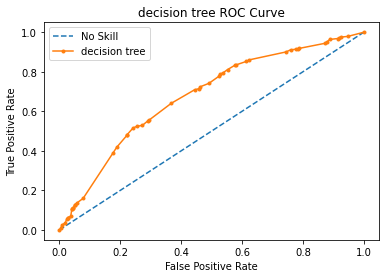

CPU times: user 156 ms, sys: 78.1 ms, total: 234 ms
Wall time: 236 ms


In [137]:
%%time

plot_roc(dt, "decision tree")